In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from typing import List, Dict
import tqdm

import torch
import torch.nn.functional as torchf
import pytorch_lightning as pl

from project.fluxdata import FluxData
from utils.data_utils import Normalize

## Data generation

$RUE_\mathrm{syn} = 0.5 \cdot e^{-(0.1 \cdot (T - 20.0))^2} \cdot \min(1.0, e^{-0.1 \cdot (VPD -  10)}) $

$GPP_\mathrm{syn} = \frac{RUE_\mathrm{syn} \cdot SW_\mathrm{in}}{12.011}$

$Rb_\mathrm{syn} = SW_\mathrm{in, pot} \cdot 0.01 - \Delta SW_\mathrm{in, pot} \cdot 0.005$

$RECO_\mathrm{syn} = Rb_\mathrm{syn} \cdot 1.5^{0.1 \cdot (TA - 15.0)}$

$NEE_\mathrm{syn} = RECO_\mathrm{syn} - GPP_\mathrm{syn}$

In [39]:
def freco(rb, q10, ta, ta_ref):
    return rb * q10 ** (0.1 * (ta - ta_ref))

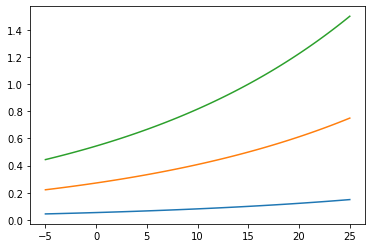

In [47]:
rb = np.linspace(0, 15, 100)
ta = np.linspace(-5, 25, 100)
reco = freco(1, 1.5, ta, 15)

plt.plot(ta, freco(0.1, 1.5, ta, 15))
plt.plot(ta, freco(0.5, 1.5, ta, 15))
plt.plot(ta, freco(1.0, 1.5, ta, 15))


In [5]:
class Model(pl.LightningModule):
    def __init__(
            self,
            features: List[str],
            targets: List[str],
            norm: Normalize,
            ds: xr.Dataset,
            hidden_dim: int=128,
            learning_rate: int=1e-3) -> None:
        """Hybrid Q10 model.

        Note that restoring is not working currently as the model training is only taking
        some minutes.
        """

        super().__init__()
        self.save_hyperparameters('features', 'targets', 'hidden_dim', 'learning_rate')

        self.features = features
        self.targets = targets

        self.input_norm = norm.get_normalizaion_layer(variables=self.features, invert=False, stack=True)
        self.l1 = torch.nn.Linear(len(self.features), self.hparams.hidden_dim)
        self.l2 = torch.nn.Linear(self.hparams.hidden_dim, len(self.targets))
        self.target_norm = norm.get_normalizaion_layer(variables=self.targets, invert=False, stack=True)
        self.target_denorm = norm.get_normalizaion_layer(variables=self.targets, invert=True, stack=True)

        self.criterion = torch.nn.MSELoss()

        self.q10 = torch.nn.Parameter(torch.ones(1))
        self.ta_ref = 15.0

        self.ds = ds
        self.q10_history = np.zeros(100000, dtype=np.float32) * np.nan

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Note that `x` is a dict of features and targets, input_norm extracts features and stacks
        # them along last dimension.
        z = self.input_norm(x)
        z = torchf.relu(self.l1(z))
        z = self.l2(z)
        rb = torchf.softplus(z)

        reco = rb * self.q10 ** (0.1 * (x['ta'] - self.ta_ref))

        return reco, rb

    def criterion_normed(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.criterion(
            self.target_norm(y_hat),
            self.target_norm(y)
        )

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        batch, _ = batch
        reco_hat, _ = self(batch)
        loss = self.criterion_normed(reco_hat, batch['reco'])
        self.q10_history[self.global_step] = self.q10.item()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log('q10', self.q10, on_step=True, on_epoch=False, prog_bar=False, logger=True)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idxL int) -> Dict[str, torch.Tensor]:
        batch, idx = batch
        reco_hat, rb_hat = self(batch)
        loss = self.criterion_normed(reco_hat, batch['reco'])
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'reco_hat': reco_hat, 'rb_hat': rb_hat, 'idx': idx}

    def validation_epoch_end(self, validation_step_outputs) -> None:
        for item in validation_step_outputs:
            reco_hat = item['reco_hat'][:, 0]          
            rb_hat = item['rb_hat'][:, 0]         
            idx = item['idx']

            self.ds['reco_pred'].values[self.current_epoch, idx] = reco_hat
            self.ds['rb_pred'].values[self.current_epoch, idx] = rb_hat

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, torch.Tensor]::
        batch, _ = batch
        reco_hat, _ = self(batch)
        loss = self.criterion_normed(reco_hat, batch['reco'])
        self.log('test_loss', loss)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    @staticmethod
    def add_model_specific_args(parent_parser: ArgumentParser) -> ArgumentParser:
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--hidden_dim', type=int, default=16)
        parser.add_argument('--learning_rate', type=float, default=0.001)
        return parser

In [6]:
def cli_main():
    pl.seed_everything(1234)

    # ------------
    # args
    # ------------
    parser = ArgumentParser(add_help=False)
    parser.add_argument('--batch_size', default=160, type=int)
    parser = pl.Trainer.add_argparse_args(parser)
    parser = Model.add_model_specific_args(parser)
    args = parser.parse_args(
        [
            '--limit_train_batches', '0.1',
            '--max_epochs', '10',
            '--log_every_n_steps', '1'
        ]
    )

    features = ['sw_pot', 'dsw_pot']
    physical = ['ta']
    targets = ['reco']

    physical_exclusive = [v for v in physical if v not in features]

    # ------------
    # data
    # ------------
    ds = xr.open_dataset('/Users/bk/Files/usmile/data/q10/Synthetic4BookChap.nc')

    fluxdata = FluxData(
        ds,
        features=features + physical_exclusive,
        targets=targets,
        context_size=1,
        train_time=slice('2003-01-01', '2006-12-31'),
        valid_time=slice('2007-01-01', '2007-12-31'),
        test_time=slice('2008-01-01', '2008-12-31'),
        batch_size=args.batch_size,
        data_loader_kwargs={'num_workers': 2})

    #return fluxdata

    norm = Normalize()
    norm.register_xr(fluxdata._ds_train)

    train_loader = fluxdata.train_dataloader()
    val_loader = fluxdata.val_dataloader()
    test_loader = fluxdata.test_dataloader()

    max_epochs = args.max_epochs if args.max_epochs is not None else 500
    ds_pred = fluxdata.target_xr('valid', varnames=['reco', 'rb'], num_epochs=max_epochs)

    # ------------
    # model
    # ------------
    model = Model(
        features=features,
        targets=targets,
        norm=norm,
        ds=ds_pred,
        hidden_dim=args.hidden_dim,
        learning_rate=args.learning_rate)

    #return fluxdata

    print(model.input_norm)
    print(model.target_norm)
    print(model.target_denorm)

    # ------------
    # training
    # ------------
    trainer = pl.Trainer.from_argparse_args(args)
    trainer.fit(model, train_loader, val_loader)

    # ------------
    # testing
    # ------------
    trainer.test(test_dataloaders=test_loader)

    return model, test_loader

In [7]:
model, _ = cli_main()

Epoch 5:  28%|██▊       | 43/153 [00:08<00:20,  5.26it/s, loss=0.17, v_num=3, valid_loss=0.300] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  28%|██▊       | 43/153 [00:06<00:16,  6.62it/s, loss=0.0552, v_num=3, valid_loss=0.108]
Validating: 0it [00:00, ?it/s]
Epoch 7:  28%|██▊       | 43/153 [00:05<00:15,  7.21it/s, loss=0.0153, v_num=3, valid_loss=0.0273]
Validating: 0it [00:00, ?it/s]
Epoch 8:  28%|██▊       | 43/153 [00:05<00:15,  7.30it/s, loss=0.00646, v_num=3, valid_loss=0.00857]
Validating: 0it [00:00, ?it/s]
Epoch 9:  28%|██▊       | 43/153 [00:05<00:13,  7.98it/s, loss=0.00504, v_num=3, valid_loss=0.00536]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 153/153 [00:32<00:00,  4.66it/s, loss=0.00504, v_num=3, valid_loss=0.00405]
Testing: 0it [00:00, ?it/s]/Users/bk/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing

In [18]:
from cycler import cycler
from matplotlib import cm as cmap

In [21]:
cm.jet(np.linspace(0, 1, 10))

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.        , 0.99910873, 1.        ],
       [0.        , 0.37843137, 1.        , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [0.30044276, 1.        , 0.66729918, 1.        ],
       [0.66729918, 1.        , 0.30044276, 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [1.        , 0.48002905, 0.        , 1.        ],
       [0.99910873, 0.07334786, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

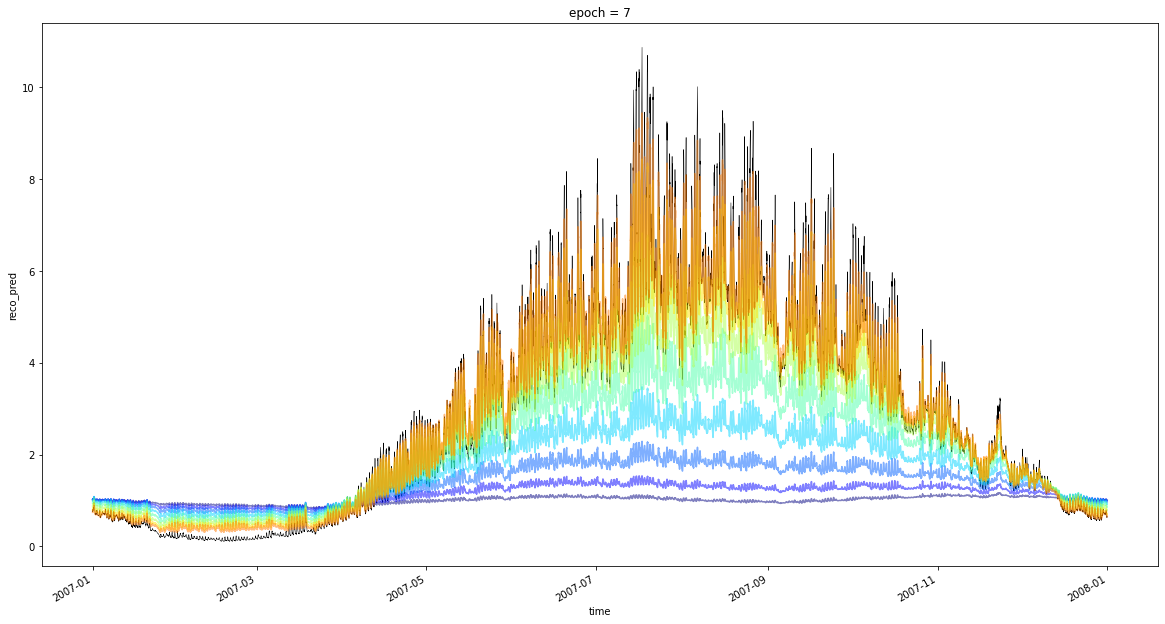

In [37]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler(color=cm.jet(np.linspace(0, 1, 10))))


model.ds['reco'].plot(color='k', lw=0.5)
for i in range(8):
    model.ds['reco_pred'].isel(epoch=i).plot(alpha=0.5, ax=ax)

In [15]:
model.ds.reco_pred.plot.line(x='time', hue='epoch', cmap='RdYlBu');

AttributeError: 'Line2D' object has no property 'cmap'

In [13]:
ds = fluxdata.target_xr('valid', ['reco', 'rb'], num_epochs=500)

In [14]:
ds

<xarray.Dataset>
Dimensions:    (epoch: 500, time: 17520)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:15:00 ... 2007-12-31T23:45:00
  * epoch      (epoch) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    reco       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    rb         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    reco_pred  (epoch, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    rb_pred    (epoch, time) float64 nan nan nan nan nan ... nan nan nan nan nan

In [15]:
ds['reco_pred'].values[0, 0] = 1.

In [16]:
ds['reco_pred'].values[0, 0]

1.0

In [6]:
idx = torch.tensor(np.arange(10))

In [10]:
ds['reco_pred'].values[0, idx]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [1]:
ds

NameError: name 'ds' is not defined

In [7]:
ds = fluxdata.add_scalar_record(ds, 'q10', np.arange(10))

In [9]:
ds = fluxdata.add_scalar_record(ds, 'q11', np.arange(10))

In [11]:
ds = fluxdata.add_scalar_record(ds, 'q11', np.arange(11))

ValueError: dimension `iter` already exists in `ds`, but lengths (10) does not match length of `x` (11).

In [6]:
physical_exclusive

['ta']

In [10]:
t = fluxdata._ds_valid[fluxdata.targets]

In [25]:
t = t.assign_coords({'iter': np.arange(4)})

In [26]:
t

<xarray.Dataset>
Dimensions:   (iter: 4, itert = : 4, time: 17520)
Coordinates:
  * time      (time) datetime64[ns] 2007-01-01T00:15:00 ... 2007-12-31T23:45:00
  * itert =   (itert = ) int64 0 1 2 3
  * iter      (iter) int64 0 1 2 3
Data variables:
    reco      (time) float64 0.7601 0.7936 0.7811 ... 0.6356 0.6393 0.6525

In [28]:
t['new'] = ('iter', [1, 2, 3, 4])

In [29]:
t

<xarray.Dataset>
Dimensions:   (iter: 4, itert = : 4, time: 17520)
Coordinates:
  * time      (time) datetime64[ns] 2007-01-01T00:15:00 ... 2007-12-31T23:45:00
  * itert =   (itert = ) int64 0 1 2 3
  * iter      (iter) int64 0 1 2 3
Data variables:
    reco      (time) float64 0.7601 0.7936 0.7811 ... 0.6356 0.6393 0.6525
    new       (iter) int64 1 2 3 4

In [22]:
t.assign(variables={'new': 1}, dim='time')

ValueError: cannot specify both keyword and positional arguments to .assign

In [19]:
help(t.assign)

Help on method assign in module xarray.core.dataset:

assign(variables: Mapping[Hashable, Any] = None, **variables_kwargs: Hashable) -> 'Dataset' method of xarray.core.dataset.Dataset instance
    Assign new data variables to a Dataset, returning a new object
    with all the original variables in addition to the new ones.
    
    Parameters
    ----------
    variables : mapping of hashable to Any
        Mapping from variables names to the new values. If the new values
        are callable, they are computed on the Dataset and assigned to new
        data variables. If the values are not callable, (e.g. a DataArray,
        scalar, or array), they are simply assigned.
    **variables_kwargs
        The keyword arguments form of ``variables``.
        One of variables or variables_kwargs must be provided.
    
    Returns
    -------
    ds : Dataset
        A new Dataset with the new variables in addition to all the
        existing variables.
    
    Notes
    -----
    Since ``kw

In [4]:
m, dl = cli_main()

Global seed set to 1234
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type     | Params
-------------------------------------------
0 | input_norm    | DataNorm | 0     
1 | l1            | Linear   | 64    
2 | l2            | Linear   | 17    
3 | target_norm   | DataNorm | 0     
4 | target_denorm | DataNorm | 0     
5 | criterion     | MSELoss  | 0     
-------------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)
DataNorm(variables=[ta, sw_pot, dsw_pot], stack=True)
DataNorm(variables=[reco], stack=True)
DataDenorm(variables=[reco], stack=True)
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]/Users/bk/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing 

KeyboardInterrupt: 

In [20]:
ds_new = xr.Dataset()

In [21]:
ds_new['r'] = ds['reco']

In [32]:
ds_new.expand_dims(rep=np.arange(10))

<xarray.Dataset>
Dimensions:  (rep: 10, time: 175344)
Coordinates:
  * rep      (rep) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 2003-01-01T00:15:00 ... 2012-12-31T23:45:00
Data variables:
    r        (rep, time) float64 0.8447 0.8406 0.8376 0.8434 ... nan nan nan nan

In [26]:
help(ds_new.expand_dims)

Help on method expand_dims in module xarray.core.dataset:

expand_dims(dim: Union[NoneType, Hashable, Sequence[Hashable], Mapping[Hashable, Any]] = None, axis: Union[NoneType, int, Sequence[int]] = None, **dim_kwargs: Any) -> 'Dataset' method of xarray.core.dataset.Dataset instance
    Return a new object with an additional axis (or axes) inserted at
    the corresponding position in the array shape.  The new object is a
    view into the underlying array, not a copy.
    
    If dim is already a scalar coordinate, it will be promoted to a 1D
    coordinate consisting of a single value.
    
    Parameters
    ----------
    dim : hashable, sequence of hashable, mapping, or None
        Dimensions to include on the new variable. If provided as hashable
        or sequence of hashable, then dimensions are inserted with length
        1. If provided as a mapping, then the keys are the new dimensions
        and the values are either integers (giving the length of the new
        dimensio

<xarray.Dataset>
Dimensions:  (time: 17520)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01T00:15:00 ... 2007-12-31T23:45:00
Data variables:
    sw_pot   (time) float64 109.8 109.8 109.8 109.8 ... 109.8 109.8 109.8 109.8
    dsw_pot  (time) float64 115.6 115.6 115.6 115.6 ... 115.6 115.6 115.6 115.6
    ta       (time) float64 -0.504 0.561 0.168 0.104 ... -4.917 -4.774 -4.268
    reco     (time) float64 0.7601 0.7936 0.7811 0.7791 ... 0.6356 0.6393 0.6525
    rb       (time) float64 1.425 1.425 1.425 1.425 ... 1.425 1.425 1.425 1.425

In [2]:
fluxdata.ta

NameError: name 'fluxdata' is not defined

In [22]:
reco = []
reco_obs = []
rb = []
rb_obs = []

for batch in tqdm.tqdm(dl):
    reco_i, rb_i = m(batch)
    reco.append(reco_i.detach().numpy())
    reco_obs.append(batch['reco'])
    rb.append(rb_i.detach().numpy())

100%|██████████| 110/110 [00:11<00:00,  9.17it/s]


In [23]:
reco_hat = np.concatenate(reco)[:, 0]
reco_obs_ = np.concatenate(reco_obs)[:, 0]

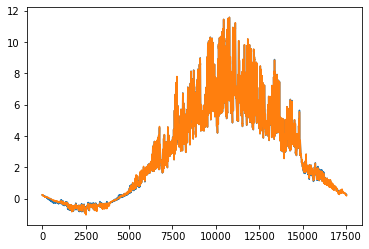

In [25]:
plt.plot(reco_hat)
plt.plot(reco_obs_)

In [24]:
(rb_i * 1.5 ** (0.1 * (batch['ta'] - 15.))).shape

torch.Size([80, 80, 1])

In [25]:
rb_i.shape

torch.Size([80, 1, 1])

In [32]:
torch.cat(list(batch.values()), dim=-1).shape

torch.Size([80, 4])

In [29]:
batch['ta'].shape

torch.Size([80, 1])

In [10]:
ds = xr.open_dataset('/Users/bk/Files/usmile/data/q10/Synthetic4BookChap.nc')

In [12]:
ds.ta.expand_dims({'new': 10})

<xarray.DataArray 'ta' (new: 10, time: 157776)>
array([[2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ],
       [2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ],
       [2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ],
       ...,
       [2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ],
       [2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ],
       [2.0999999 , 1.98000002, 1.88999999, ..., 0.14      , 0.27000001,
        0.31      ]])
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T00:15:00 ... 2011-12-31T23:45:00
Dimensions without coordinates: new

In [3]:
ds.time[0]

<xarray.DataArray 'time' ()>
array('2003-01-01T00:15:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2003-01-01T00:15:00

In [89]:
ds.rb.notnull().sum()

<xarray.DataArray 'rb' ()>
array(157776)

(array([1.1000e+01, 4.6000e+01, 5.8000e+01, 5.6200e+02, 3.8810e+03,
        1.2304e+04, 5.5600e+02, 5.5000e+01, 4.3000e+01, 4.0000e+00]),
 array([-5.32907052e-15, -4.26325641e-15, -3.19744231e-15, -2.13162821e-15,
        -1.06581410e-15,  0.00000000e+00,  1.06581410e-15,  2.13162821e-15,
         3.19744231e-15,  4.26325641e-15,  5.32907052e-15]),
 <BarContainer object of 10 artists>)

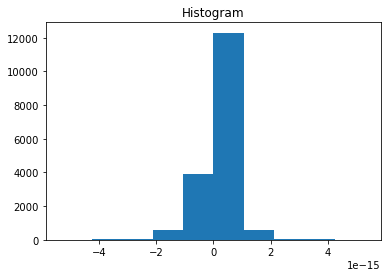

In [9]:
(ds['reco'] - ds['rb'] * 1.5 ** ((ds['ta'] - 15.) * 0.1)).plot.hist()

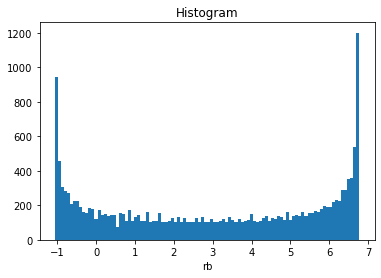

In [7]:
ds['rb'].plot.hist(bins=100);

In [9]:
import pandas as pd

In [91]:
d = pd.read_csv('/Users/bk/Files/usmile/data/q10/Synthetic4BookChap.csv')

In [92]:
d

,siteID,DateTime,wdefCum,H2Ostor1,H2Ostor2,Drainage,SW_POT_sm,SW_POT_sm_diff,useit,seqID,...,NEE_QC_OK,SWC_1_QC_OK,SWC_2_QC_OK,SW_IN_QC_OK,TA_QC_OK,TS_1_QC_OK,TS_2_QC_OK,VPD_QC_OK,GPP_NT_QC_OK,GPP_DT_QC_OK
0,AT-Neu,2002-01-01T00:15:00Z,0.000000,40.000000,160.000000,0.000,NaN,NaN,False,1,...,1,0,0,1,1,1,0,1,1,1
1,AT-Neu,2002-01-01T00:45:00Z,-0.000379,39.999659,159.999962,0.000,NaN,NaN,False,1,...,1,0,0,1,1,1,0,1,1,1
2,AT-Neu,2002-01-01T01:15:00Z,-0.000758,39.999318,159.999924,0.000,NaN,NaN,False,1,...,1,0,0,1,1,1,0,1,1,1
3,AT-Neu,2002-01-01T01:45:00Z,-0.001204,39.998916,159.999880,0.001,NaN,NaN,False,1,...,1,0,0,1,1,1,0,1,1,1
4,AT-Neu,2002-01-01T02:15:00Z,0.000000,40.000000,160.000000,0.000,NaN,NaN,True,1,...,1,0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192859,AT-Neu,2012-12-31T21:45:00Z,-66.446636,40.000000,93.553364,0.000,NaN,NaN,False,2009,...,1,1,1,1,1,1,1,1,1,1
192860,AT-Neu,2012-12-31T22:15:00Z,-66.440884,40.000000,93.559116,0.000,NaN,NaN,False,2009,...,1,1,1,1,1,1,1,1,1,1
192861,AT-Neu,2012-12-31T22:45:00Z,-66.435324,40.000000,93.564676,0.000,NaN,NaN,False,2009,...,1,1,1,1,1,1,1,1,1,1
192862,AT-Neu,2012-12-31T23:15:00Z,-66.429510,40.000000,93.570490,0.000,NaN,NaN,False,2009,...,1,1,1,1,1,1,1,1,1,1


In [18]:
d['Rb_syn'][:10000].min()

0.2386302194282828

In [28]:
parser = ArgumentParser(add_help=False)
parser.add_argument('--batch_size', default=160, type=int)
parser.add_argument('--gradient_clip_val', default=0.1, type=float)
args = parser.parse_args('')

In [29]:
args

Namespace(batch_size=160, gradient_clip_val=0.1)

In [31]:
parser = ArgumentParser(add_help=False)
parser.add_argument('--batch_size', default=160, type=int)
parser.add_argument('--gradient_clip_val', default=0.1, type=float)
parser = pl.Trainer.add_argparse_args(parser)
parser = Model.add_model_specific_args(parser)
args = parser.parse_args(['--gradient_clip_val'])

ArgumentError: argument --gradient_clip_val: conflicting option string: --gradient_clip_val

In [44]:
import shlex
parser = ArgumentParser(add_help=False)
parser.add_argument('--batch_size', default=160, type=int)
parser.add_argument('--gradient_clip_val', default=0.1, type=float)
argString = '--batch_size 16'
args = parser.parse_args(['--batch_size', '18'])

In [45]:
args

Namespace(batch_size=18, gradient_clip_val=0.1)

In [46]:
shlex.split(argString)

['--batch_size', '16']